In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gensim import corpora, models
from wordcloud import WordCloud
import pandas as pd
from collections import Counter
import plotly.express as px
import matplotlib.pyplot as plt
import spacy
from collections import Counter
import pandas as pd
import plotly.express as px

In [ ]:
data = pd.read_csv('/predicted-dateset.csv')

# Daily Average Score Over Time

<ipython-input-5-b92ee03f1a28>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  daily_avg_score = df.resample('D', on='created_time').mean()


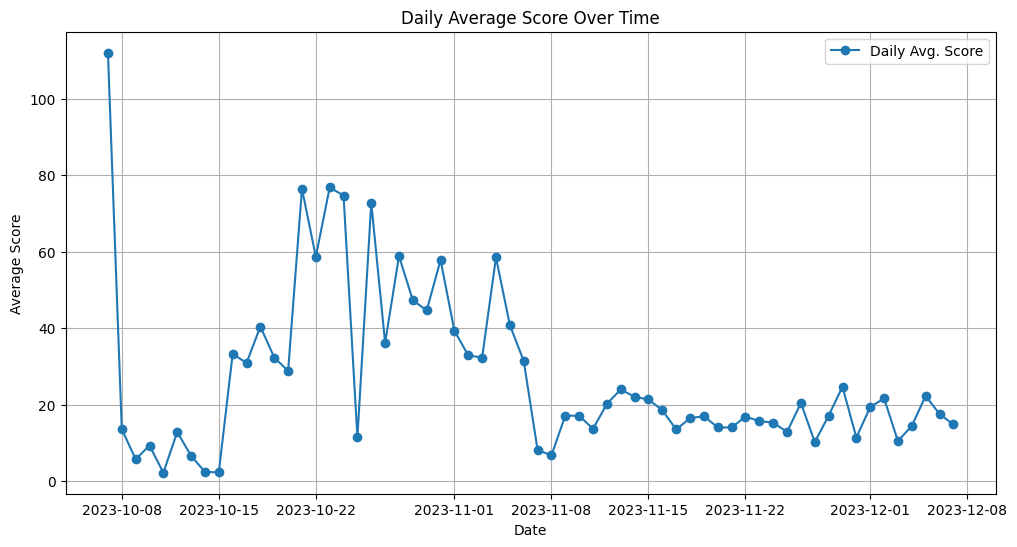

In [ ]:
df = data
df['created_time'] = pd.to_datetime(df['created_time'])
daily_avg_score = df.resample('D', on='created_time').mean()
plt.figure(figsize=(12, 6))
plt.plot(daily_avg_score.index, daily_avg_score['score'], marker='o', label='Daily Avg. Score')

plt.title('Daily Average Score Over Time')
plt.xlabel('Date')
plt.ylabel('Average Score')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
result = data.groupby('predicted_label').agg({
    'self_text': 'count',
    'score': 'mean',
    'controversiality': 'mean'
}).reset_index()

result

,predicted_label,self_text,score,controversiality
0,neutral,46603,19.402807,0.058945
1,pro-Israel,34344,19.147828,0.055643
2,pro-Palestine,44032,18.894168,0.060433
3,strongly pro-Israel,11452,17.611284,0.053802
4,strongly pro-Palestine,241817,19.897906,0.062163


# Distribution of Sentiment

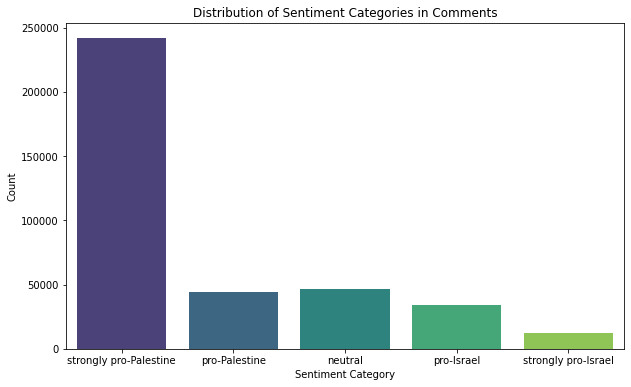

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='predicted_label', data=data, palette='viridis')
plt.title('Distribution of Sentiment Categories in Comments')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

In [ ]:
sentiment_counts = data['predicted_label'].value_counts()
print('Sentiment Category Counts:')
print(sentiment_counts)


Sentiment Category Counts:
strongly pro-Palestine    241817
neutral                    46603
pro-Palestine              44032
pro-Israel                 34344
strongly pro-Israel        12230
Name: predicted_label, dtype: int64


# World Cloud

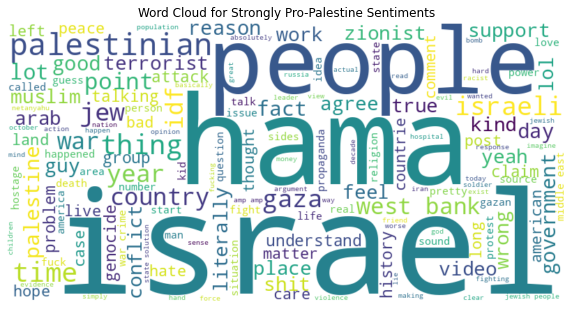

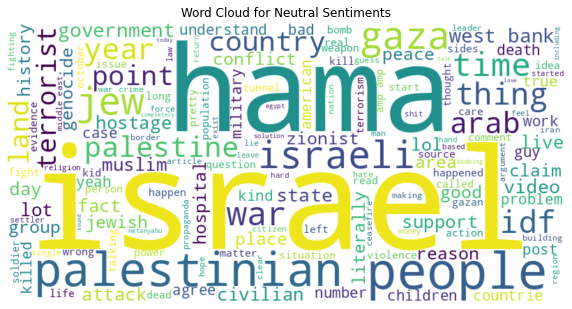

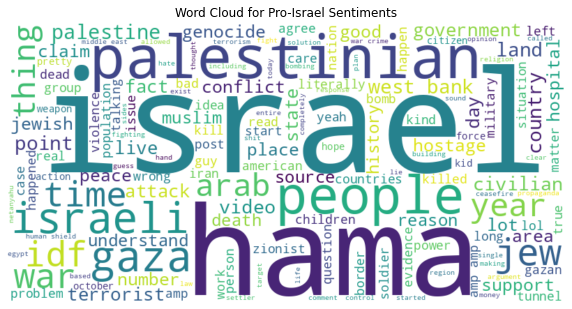

In [ ]:
unique_pro_palestine_text = ' '.join(data[data['predicted_label'] == 'strongly pro-Palestine']['self_text']).lower()
unique_neutral_text = ' '.join(data[data['predicted_label'] == 'neutral']['self_text']).lower()
unique_pro_israel_text = ' '.join(data[data['predicted_label'] == 'pro-Israel']['self_text']).lower()

wordcloud_pro_palestine = WordCloud(width=800, height=400, background_color='white', max_words=150).generate(unique_pro_palestine_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_pro_palestine, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Strongly Pro-Palestine Sentiments')
plt.show()

wordcloud_neutral = WordCloud(width=800, height=400, background_color='white', max_words=150).generate(unique_neutral_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Neutral Sentiments')
plt.show()

wordcloud_pro_israel = WordCloud(width=800, height=400, background_color='white', max_words=150).generate(unique_pro_israel_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_pro_israel, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Pro-Israel Sentiments')
plt.show()

# Topic Modeling

In [ ]:
documents = data['self_text'].fillna('').astype(str).values.tolist()
stopwords = set([])

texts = [
    [word for word in document.lower().split() if word not in stopwords]
    for document in documents
]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_model = models.LdaModel(corpus, num_topics=3, id2word=dictionary, passes=15)

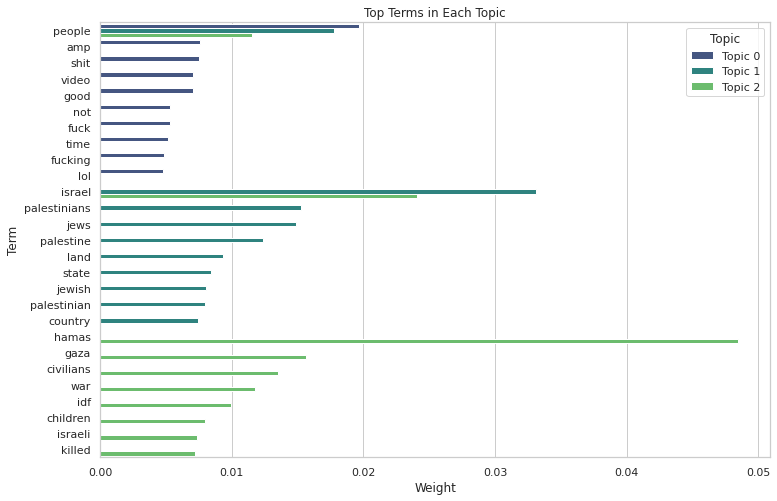

In [ ]:
topic_terms = [lda_model.get_topic_terms(topic_id, topn=10) for topic_id in range(lda_model.num_topics)]
topics_data = []
for topic_id, terms in enumerate(topic_terms):
    topic_data = {'Term': [], 'Weight': [], 'Topic': []}
    for term, weight in terms:
        topic_data['Term'].append(dictionary[term])
        topic_data['Weight'].append(weight)
        topic_data['Topic'].append(f'Topic {topic_id}')
    topics_data.append(pd.DataFrame(topic_data))

topics_df = pd.concat(topics_data, ignore_index=True)
plt.figure(figsize=(12, 8))
sns.barplot(x='Weight', y='Term', hue='Topic', data=topics_df, palette='viridis')
plt.title('Top Terms in Each Topic')
plt.xlabel('Weight')
plt.ylabel('Term')
plt.show()

# Entity Analysis

In [ ]:
nlp = spacy.load("en_core_web_sm")

data['self_text'] = data['self_text'].astype(str)

all_entities = []
for _, row in data.iterrows():
    doc = nlp(row['self_text'])
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    all_entities.extend(entities)

entity_counts = Counter(all_entities)
entity_df = pd.DataFrame(list(entity_counts.items()), columns=['Entity', 'Count'])
entity_df = entity_df.sort_values(by='Count', ascending=False)


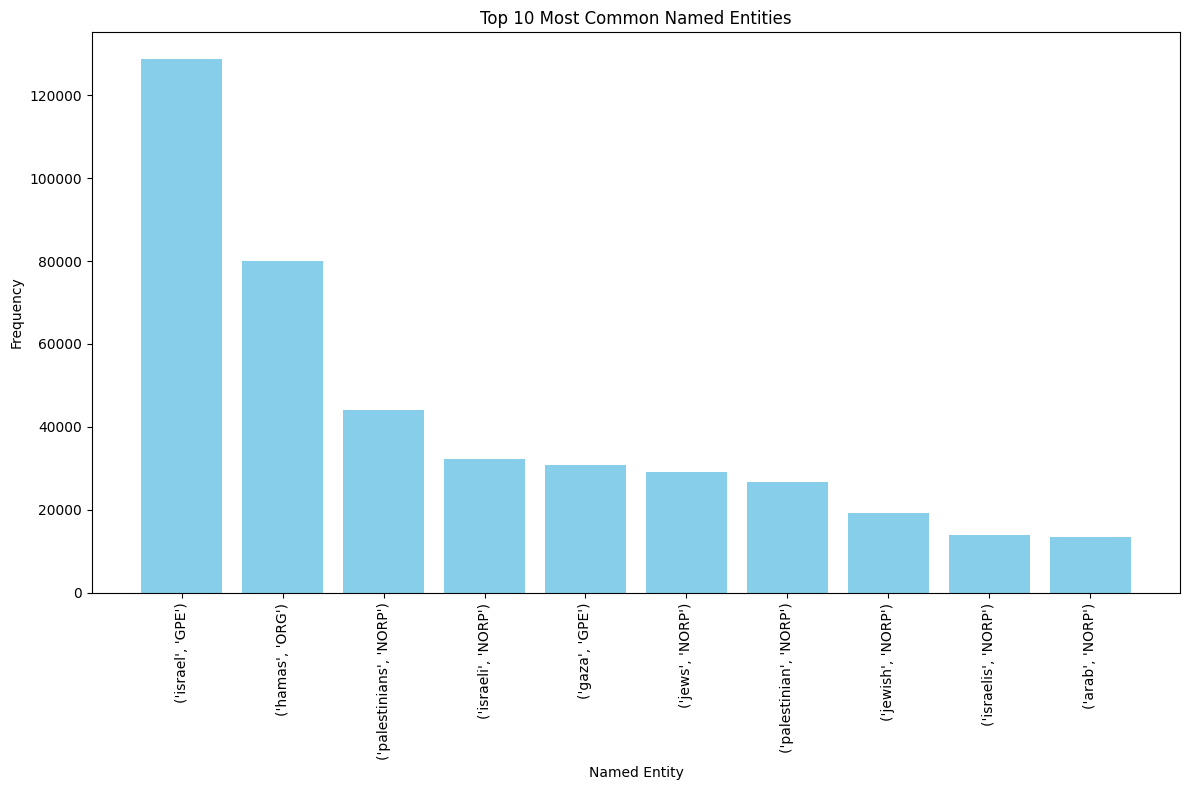

In [12]:
top_n = 10

plt.figure(figsize=(12, 8))
plt.bar(entity_df['Entity'].astype(str)[:top_n], entity_df['Count'][:top_n], color='skyblue')
plt.title(f'Top {top_n} Most Common Named Entities')
plt.xlabel('Named Entity')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Temporal Analysis

Unique values in 'controversiality' column: [0 1]
Number of entries with controversiality equal to 1: 31
High Score and Controversial Posts (Above Threshold and Controversiality=1):
               predicted_label  score  controversiality
30452   strongly pro-Palestine   5354                 0
31589   strongly pro-Palestine   5634                 0
57697                  neutral   5568                 0
87634   strongly pro-Palestine   6140                 0
90524   strongly pro-Palestine   7588                 0
90749               pro-Israel   7771                 0
101534  strongly pro-Palestine   6281                 0
120192  strongly pro-Palestine   5034                 0
120351  strongly pro-Palestine   7973                 0
159379  strongly pro-Palestine   5286                 0
195569                 neutral   5680                 0
245746  strongly pro-Palestine   7723                 0
256597  strongly pro-Palestine   5067                 0
260366              pro-Israel   5

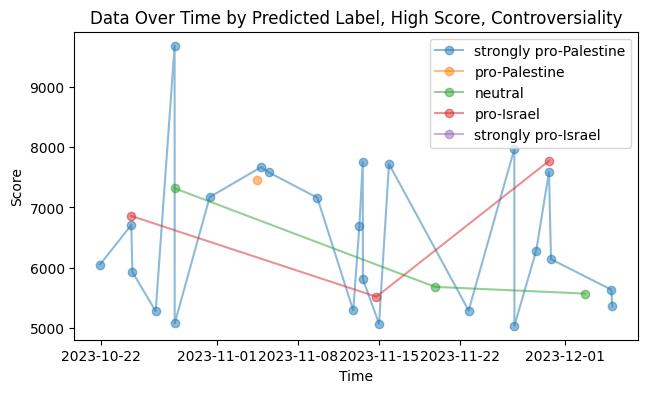

In [13]:
df = data

df['created_time'] = pd.to_datetime(df['created_time'])
print("Unique values in 'controversiality' column:", df['controversiality'].unique())
score_threshold = 5000
high_score_controversial_posts = df[(df['score'] > score_threshold)]
print("Number of entries with controversiality equal to 1:", len(high_score_controversial_posts))
print("High Score and Controversial Posts (Above Threshold and Controversiality=1):")
print(high_score_controversial_posts[['predicted_label', 'score', 'controversiality']])

plt.figure(figsize=(16, 10))
plt.subplots_adjust(hspace=0.5)
labels = df['predicted_label'].unique()
label_colors = {label: sns.color_palette()[i] for i, label in enumerate(labels)}

plt.subplot(2, 2, 1)
for label, color in label_colors.items():
    label_df = high_score_controversial_posts[high_score_controversial_posts['predicted_label'] == label]
    plt.plot(label_df['created_time'], label_df['score'], marker='o', label=label, alpha=0.5, color=color, linestyle='-')

plt.title('Data Over Time by Predicted Label, High Score, Controversiality')
plt.xlabel('Time')
plt.ylabel('Score')
plt.legend()
plt.savefig("/output_plots_high_score_controversial.png")
high_score_controversial_posts.to_csv("/output_plots_high_score_controversial.csv", index=False)
plt.show()


In [7]:
high_score = pd.read_csv("output_plots_high_score_controversial.csv")
high_score

,self_text,subreddit,created_time,score,controversiality,predicted_label
0,evidence support claim limb fake,TerrifyingAsFuck,2023-12-05 02:58:34,5354,0,strongly pro-Palestine
1,friendly reminder rule geneva conventions stat...,worldnews,2023-12-05 00:23:04,5634,0,strongly pro-Palestine
2,stick philosophy mins early risking late,PublicFreakout,2023-12-02 17:54:18,5568,0,neutral
3,disgusting famalies hell harrassment victims p...,worldnews,2023-11-29 19:47:33,6140,0,strongly pro-Palestine
4,death youngest hostage murder terrorists baby,worldnews,2023-11-29 15:35:40,7588,0,strongly pro-Palestine
5,month,worldnews,2023-11-29 15:12:36,7771,0,pro-Israel
6,arrived gaza residents beat child west gon rea...,worldnews,2023-11-28 13:08:34,6281,0,strongly pro-Palestine
7,exact thing nuclear arms decade ago,worldnews,2023-11-26 16:03:28,5034,0,strongly pro-Palestine
8,fears unfounded russia ukraine violating budap...,worldnews,2023-11-26 15:51:21,7973,0,strongly pro-Palestine
9,white house support israel plan expand operati...,worldnews,2023-11-22 17:13:30,5286,0,strongly pro-Palestine
